<h1>$\textbf{Global Land Temperature Analysis and Forecasting}$</h1>




$\textit{Author : Ioannis Kontogiorgakis}$<br>
<!-- $\textit{Professor : Dionysios Christopoulos}$<br> -->
$\textit{Date : February 9, 2023}$<br>
<br>


## Introduction

This project delves into the analysis and forecasting of land temperature in Athens, Greece, leveraging historical data to gain insights and predict future trends. Through comprehensive analysis, including time series decomposition, stationarity testing, and model evaluation, we aim to uncover underlying patterns and dynamics within the temperature data. Utilizing advanced forecasting techniques, we seek to generate accurate predictions for the temperature over the course of the next year. By combining data analysis with predictive modeling, this study contributes to a deeper understanding of temperature variations in Athens and provides valuable insights for climate monitoring and planning.
<br>
Algorithms tested:
- SARIMA
- XGBoost
- LSTM Neural Network

<br><br>

## Dataset

The dataset was acquired from Berkley Earth, a non-profit organization dedicated to analyzing and disseminating data related to Earth's climate. It contains monthly temperatures for various cities starting from 1900 to 2013. In this study, we will focus on temperatures originated from Athens, Greece.

<br><br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.dates import DateFormatter, DayLocator

import math
import statsmodels.api as sm
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE, mean_absolute_percentage_error as MAPE,r2_score
from xgboost import XGBRegressor

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats import diagnostic as diag
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator

<br><br>
Read the data for Temperature Anomaly inferred from Sea

In [ ]:
cities = pd.read_csv('/content/drive/MyDrive/capstone/data/GlobalLandTemperaturesByCity.csv')
ath = cities.loc[cities['City'] == 'Athens', ['dt','AverageTemperature']]
ath.columns = ['Date','Temp']
ath['Date'] = pd.to_datetime(ath['Date'])
ath.reset_index(drop=True, inplace=True)
ath.set_index('Date', inplace=True)

#I'm going to consider the temperature just from 1900 until the end of 2012
ath = ath.loc['1979':'2013-01-01']
ath = ath.asfreq('M', method='bfill')
ath.head()

,Temp
Date,
1979-01-31,11.482
1979-02-28,13.711
1979-03-31,14.582
1979-04-30,19.349
1979-05-31,24.503


Lets declare some functions that will be useful for out time series analysis.

In [ ]:
def evaluate_model(y_test, y_pred):
    """
    Calculate model prediction metrics.

    Parameters:
    - y_test (array-like): True values of the target variable.
    - y_pred (array-like): Predicted values of the target variable.

    Returns:
    - None
    """
    mape = MAPE(y_test, y_pred)
    mae = MAE(y_test, y_pred)
    mse = MSE(y_test, y_pred, squared=True)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'MAPE : {mape}')
    print(f'MAE : {mae}')
    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'r2 : {r2}')

In [ ]:
def plot_ts(df):
    """
    Plots the time series of temperature data.

    Parameters:
    - df (DataFrame): DataFrame containing the temperature data with DateTimeIndex.
    - dpi (int): Dots per inch for the figure resolution.

    Returns:
    - None
    """
    plt.figure(figsize=(22,8), dpi=100)
    plt.plot(df.index, df.Temp, color='tab:blue')
    plt.gca().set(title=f"Average Land Temperature", xlabel='Date', ylabel='Temperature')
    plt.show()

In [ ]:
def plot_single_model(model_name, df_test, forecasts):
    """
    Visualizes the results of the fitted best model.

    Parameters:
    - model_name (str): Name of the model being visualized.
    - df_test (DataFrame): DataFrame containing the test data.
    - forecasts (array-like): Array-like object containing the forecasted values.

    Returns:
    - None
    """

    # if df_test constains 'Month' and 'Year' columns
    if len(df_test.columns) > 1:
        # Concatenate 'Year' and 'Month' columns into a single date column
        df_test['Date'] = pd.to_datetime(df_test[['Year', 'Month']].assign(Day=1))
        df_test.set_index('Date', inplace=True)
        df_test.drop(['Year', 'Month'], axis=1, inplace=True)

    title = f'Best {model_name} model'
    plt.figure(figsize=(16,8))
    plt.plot(df_test, label='Ground Truth', marker='o', color='blue')
    plt.plot(df_test.index,forecasts, label='Prediction' , marker='x', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Temperature Anomaly')
    plt.axvline(df_test.index[0], color='black', alpha=0.5, linestyle='--')
    plt.savefig('best_model_forecasting_results.png')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def plot_future_forecast(model_name, df, forecast_years, forecasts):
    """
    Visualizes the future forecast based on the best model.

    Parameters:
    - model_name (str): Name of the model being visualized.
    - df (DataFrame): DataFrame containing the historical data.
    - forecast_years (int): Number of years into the future to forecast.
    - forecasts (array-like): Array-like object containing the forecasted values.

    Returns:
    - None
    """
    # Get the last date in our ath DataFrame
    last_date = df.index[-1]

    # Generate date indices for one year into the future
    future_indices = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_years * 12, freq='M')

    title = f'Best {model_name} model'
    plt.figure(figsize=(16, 8))
    plt.plot(df.loc['2000':'2013-01-01'], label='Ground Truth', color='blue')
    plt.plot(future_indices, forecasts, label='Forecast', color='orange')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Temperature Anomaly')
    plt.axvline(df_test.index[0], color='black', alpha=0.5, linestyle='--')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def plot_yearly_temp(df):
    """
    Plots the yearly temperatures in Athens.

    Parameters:
    - df (DataFrame): DataFrame containing the temperature data with a Datetime index.

    Returns:
    - None
    """
    dfp = df.copy()
    dfp['month']=dfp.index.month
    dfp['year']=df.index.year

    pivot=pd.pivot_table(dfp,values='Temp',index='month',columns='year',aggfunc='mean')
    pivot.plot(figsize=(22,6))
    plt.title('Yearly Tempertaures in Athens')
    plt.xlabel('Month')
    plt.ylabel('Temperature')
    plt.xticks([x for x in range(1,13)])
    plt.legend().remove()
    plt.show()

In [ ]:
def series_decomposition(df):
    """
    Decomposes the time series into trend, seasonal, and residual components using additive seasonal decomposition.

    Parameters:
    - df (DataFrame): DataFrame containing the time series with a Datetime index and 'Temp' column.

    Returns:
    - None
    """
    # Decompose time series
    decomposition = seasonal_decompose(df['Temp'], model='additive')
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot decomposed components
    plt.figure(figsize=(18, 8))
    plt.subplot(411)
    plt.plot(df['Temp'], label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='upper left')
    plt.gca().set(title=f"Series Decomposition")
    plt.tight_layout()
    plt.show()

In [ ]:
def check_stationarity(df):
    """
    Performs AD-Fuller Test and Ljung box to check if the series is stationary.

    Parameters:
    - df (DataFrame): DataFrame containing the time series with a Datetime index and 'Temp' column.

    Returns:
    - None
    """
    print('--------')
    print('ADF test')
    print('---------\n\n')
    result = adfuller(df.Temp)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
     print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print('Augmented Dickey-Fuller test: Time-Series indicates stationarity')
    else:
        print('Augmented Dickey-Fuller test: Time-Series indicates NOT stationary')
    print('\n\n---------------------------')
    print('Ljung-Box stationarity test')
    print('---------------------------\n\n')
    print(diag.acorr_ljungbox(ath.Temp, lags=[12], return_df=True))

In [ ]:
def plot_acf_pacf_dist(df):
    """
    Plot autocorrelation function (ACF), partial autocorrelation function (PACF),
    and distribution of a time series.

    Parameters:
    - df (DataFrame): DataFrame containing the time series data.
    - figsize (tuple, optional): Figure size for the plots. Default is (16, 8).

    Returns:
    None
    """
    fig = plt.figure(figsize=(16,8))
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

    y = df['Temp']
    plot_acf(y,zero=False, ax=ax1);
    plot_pacf(y,zero=False, ax=ax2);
    sns.distplot(y,ax=ax3)
    ax3.set_title('Distribution Chart')

    # sm.qqplot(df['Monthly_Anomaly'])


    plt.tight_layout()

In [ ]:
# Reverse the differencing operation to obtain the predicted values in the original scale
def reverse_diff(original_series, diff_series):
    return original_series.shift(1) + diff_series.cumsum()

## Exploratory Data Analysis

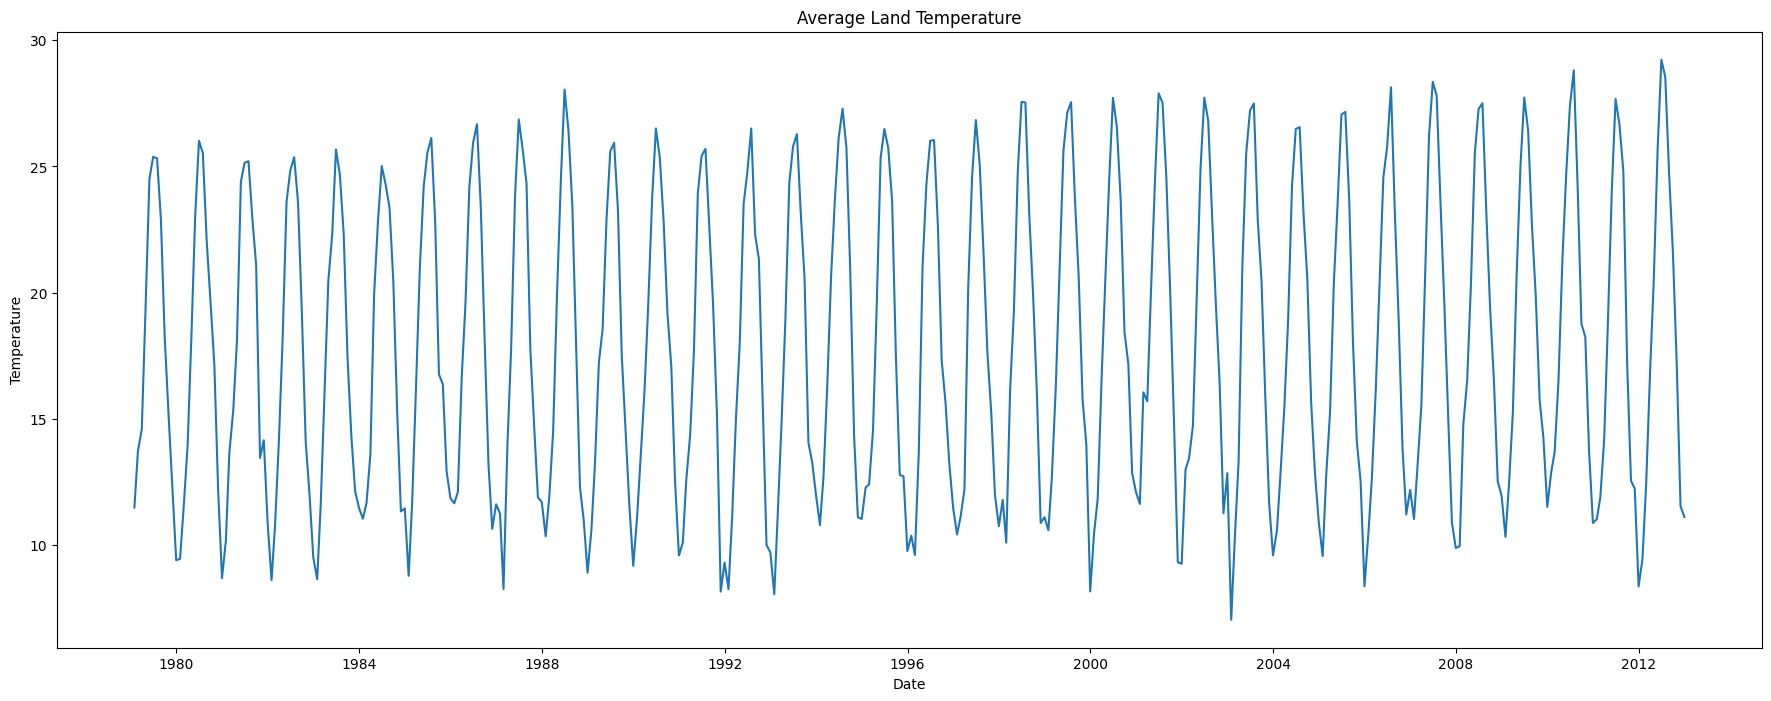

In [ ]:
plot_ts(ath)

Initial plot of the time series shows clear seasonality due to temperature variations, indicating recurring patterns over time. There is no distinct trend or extreme variations, suggesting that the time series appears to be stationary at first glance.

### Yearly Temperature in Athens

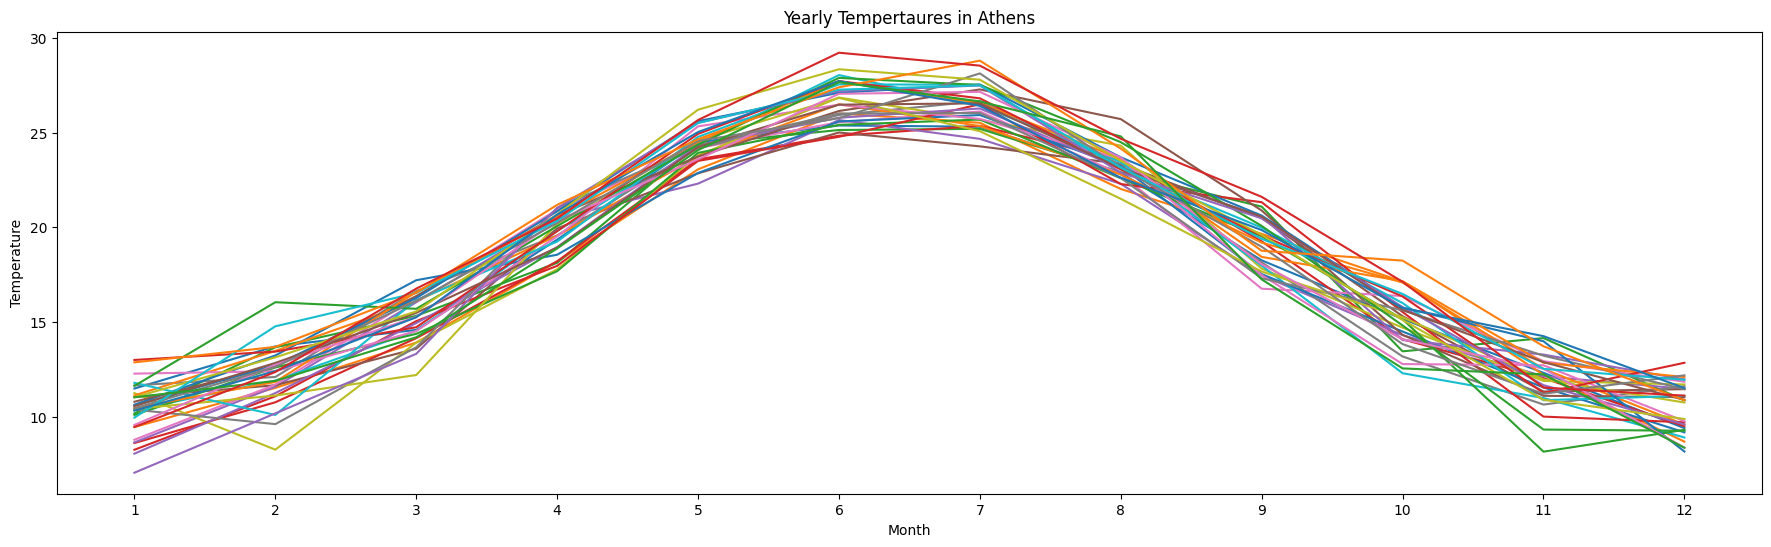

In [ ]:
plot_yearly_temp(ath)

The yearly temperatures plot reveals expected patterns, with higher temperatures occurring during the summer months and lower temperatures during the winter months. This observation aligns with our expectations, indicating that the data reflects typical seasonal variations in Athens temperatures. A high peak temperature is observed mid summer months, while low peak is observed during winter(December - January). Subsequently, we will explore the distribution of the data, along with autocorrelation and partial autocorrelation functions, to gain further insights into the underlying patterns and dependencies within the time series.

<br><br>


### Series Decomposition

In order to verify our assumptions, I performed decomposition as follows: Lets $X_t$ be our original time series. Then, we split the time series as:

$$
X_t = T_t + S_t + \epsilon_t
$$
,where $T_t$ is the trend, $S_t$ is the seasonality component and $\epsilon_t$ are the residuals.

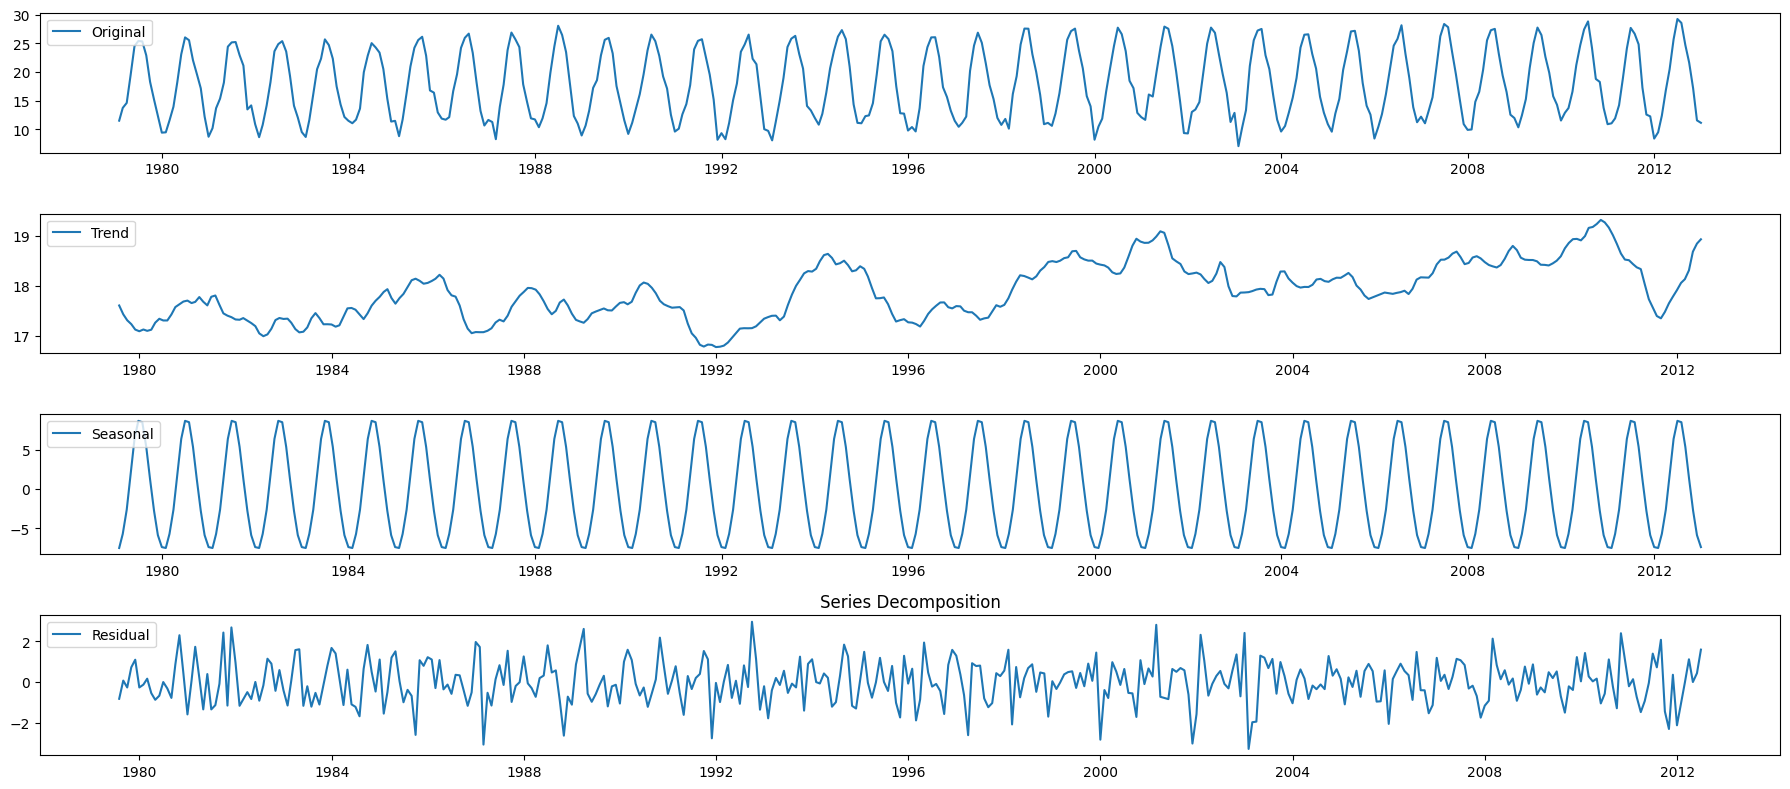

In [ ]:
series_decomposition(ath)

We can visually see the <b>seasonality</b> now. The seasonal component displays recurring patterns over time. We can see that the residuals are normally distributed across the zero axis, indicating that the model captures most of the variability in the original data. We can also observe a small upwards trend in the trend component, indicating a slight overall increase or decrease in temperature over time.

<br><br>


<br><br><br>

### Autocorrelation, Partial Autocorrelation and Distribution

The Autocorrelation Function (ACF) measures the correlation between a time series and its lagged values. It provides insights into the dependence of a data point on its past observations. The ACF at lag $\tau$, denoted as $\rho_\tau$, is defined as:

$$
\rho_\tau = \frac{\mathbb{C}ov(X_t, X_{t-\tau})}{\sqrt{\mathbb{V}ar(X_t) \cdot \mathbb{V}ar(X_{t-\tau})}}
$$

,where $X_t$ represents the time series at time $t$, $\text{{Cov}}(X_t, X_{t-\tau})$ is the covariance between $X_t$ and $X_{t-\tau}$, and $\text{Var}(X_t)$ and $\text{Var}(X_{t-\tau})$ are the variances of $X_t$ and $X_{t-\tau}$, respectively.

<br><br>

The partial autocorrelation function (PACF) measures the correlation between a time series and its lagged values after removing the effects of intermediate lags. It helps identify the direct influence of past observations on the current value. The PACF at lag $\tau$, is determined using the formula:
$$
\pi_\tau = \rho_\tau[X_{t+\tau},X_\tau | X_{t+1} = x_{t+1}, X_{t+2} = x_{t+2}, ...X_{t+\tau-1} = x_{t+\tau-1}]
$$
,where $X_t$ represents the time series at time $t$, and $\rho$ represents the above autocorrelation function.



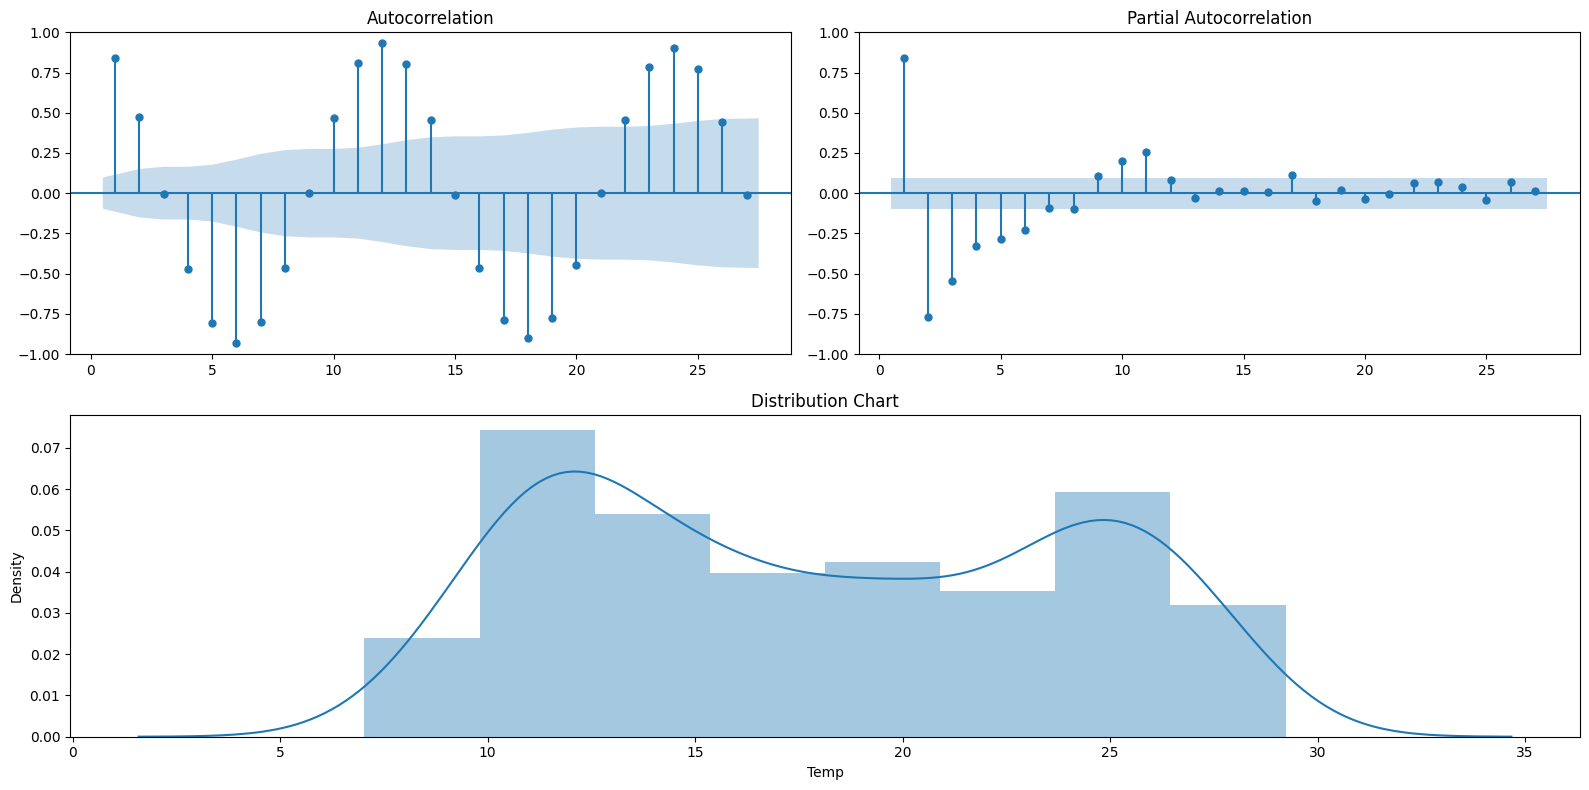

In [ ]:
plot_acf_pacf_dist(ath)

The series displays a noteworthy pattern characterized by a negative autocorrelation, particularly evident at a lag of 6 months, with a recurring cycle every 12 months. This behavior is attributed to seasonal variations, where changes in temperature during one season are inversely correlated with those occurring six months later. For instance, if the current winter season experiences cold temperatures, it's anticipated that temperatures will rise in the subsequent summer season. That's why this negative autocorrelation occurs.
<br>
From the Partial Autocorrelation plot, we observe a significant positive spike, and then a negative decline on the following lags.

### Lag plot

<Axes: title={'center': 'Lag plot at lag 1'}, xlabel='y(t)', ylabel='y(t + 1)'>

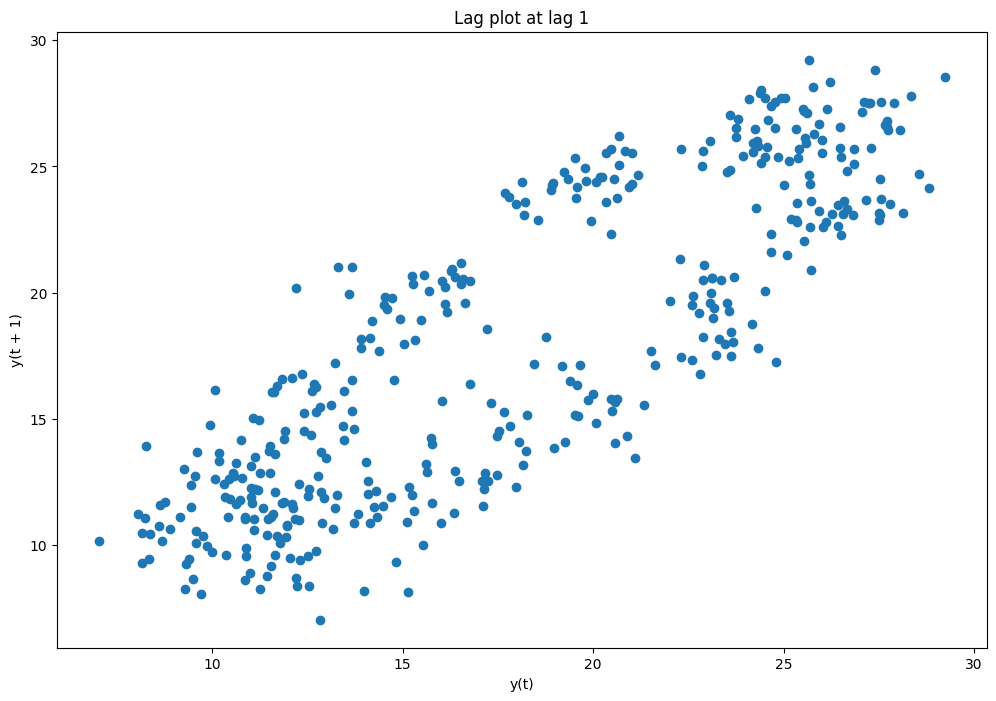

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Lag plot at lag 1')
pd.plotting.lag_plot(ath,lag=1)

The lag plot is a scatter plot of a time series against its lagged values. In this case, the shape appearing elliptical indicates that there is a correlation between each observation $t$ and its lagged value $t-1$. This suggests that the data may have some level of autocorrelation, meaning that each observation is correlated with its past values.

### Stationarity

Given the trend and seasonality identified in the series decomposition, we anticipate observing non-stationarity in the time series data. In order to verify this assumption, we are going to perform 2 stationarity tests.


<br>

<b> Augmented Dickey Fuller Test </b>

The Augmented Dickey-Fuller (ADF) test is a statistical method used to determine the stationarity of a time series. It assesses whether a unit root is present in a univariate time series dataset. The test hypotheses are as follows:

- <b>Null Hypothesis (H0) </b>: The time series has a unit root, indicating non-stationarity.
- <b>Alternative Hypothesis (H1) </b>: The time series does not have a unit root, indicating stationarity.

<br>

<b>Ljung-Box Transformation</b>

The Ljung-Box test is a statistical method used to assess the presence of autocorrelation in a time series. It evaluates whether the autocorrelations of a time series are significantly different from zero at different lag intervals. The test hypotheses are as follows:

- <b>Null Hypothesis (H0)</b>: The autocorrelations at the specified lags are zero, indicating stationarity.
- <b>Alternative Hypothesis (H1)</b>: At least one autocorrelation at the specified lags is nonzero, suggesting non-stationarity.
The test statistic is compared to critical values to determine whether to reject the null hypothesis. If the test statistic exceeds the critical value, the null hypothesis is rejected, indicating non-stationarity.

<br>

Both tests statistics are compared to critical values to determine whether to reject the null hypothesis. If the test statistic is less than the critical value, the null hypothesis is rejected. In our case, the critical value will be <b> 0.05 </b>

In [ ]:
check_stationarity(ath)

--------
ADF test
---------


ADF Statistic: -3.314073
p-value: 0.014261
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571
Augmented Dickey-Fuller test: Time-Series indicates stationarity


---------------------------
Ljung-Box stationarity test
---------------------------


        lb_stat  lb_pvalue
12  2199.793308        0.0


The p-value of 0.01 obtained from the Augmented Dickey-Fuller (ADF) test indicates strong evidence against the null hypothesis, suggesting that the time series is likely <b>stationary</b>. This implies that the observed data does not possess a unit root and exhibits stationary behavior, which is essential for accurate modeling and forecasting in time series analysis.

<br><br><br><br><br>

## Modelling and Forecasting

In this section, we are gonna implement and evaluate different models, aiming to accurately forecast temperature in Athens for a year. The forecasting methodology followed in this project is the following:



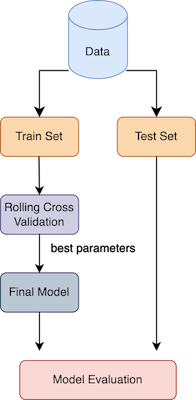

- First, we split our data in train and test according to a specific date-year. In this study, we are trying to forecast a single year, so we split our data on year 2012.
- Then, we are going to finetune 3 different models (<b>SARIMA</b>, <b>XGBoost</b>, <b>LSTM</b>) on the train set, using <b>Rolling Cross Validation</b>
- Finally, we are going to evaluate and compare the trained models on the test set, based on different metrics.
<br>


The metrics used for model evaluation are the following.
Let $X_t$ be our original temperature time series at a specific time $t$ and let $\hat{X}_t$ our forecasted time series at a specific time $t$. Then

<br>



- <b>RMSE</b> $ = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(X_i - \hat{X}_i)^2}$

<br>

- <b>MAE</b> $ = \sqrt{\frac{1}{N}\sum_{i=1}^{N}|X_i - \hat{X}_i|}$

<br>

- <b>MAPE</b> $ = \frac{1}{N}\sum_{i=1}^{N}| \frac{X_i - \hat{X}_i}{X_i}|
\times 100\%$

<br>

For the SARIMA model, we will also take into account model complexity, thus we will use 2 additional metrics: Akaike Information Criterion (<b>AIC</b>) and Bayesian Information Criterion (<b>BIC</b>)

<br>

- <b>AIC</b> $ = 2K - 2$log$\mathcal{L}$

<br>

- <b>BIC</b> $ = K$log$N - 2$log$\mathcal{L}$

<br>

where $N$ is the total number of points, $K$ is the number of parameters and $\mathcal{L}$ is the likelihood of the model. The latter metrics aim to strike a balance between the goodness of fit of a model and its complexity. By penalizing overly complex models, AIC and BIC promote the selection of more parsimonious models that effectively capture the underlying patterns in the data while avoiding overfitting.



<br><br>
 Split our data. We are going to train our model in all the previous temperature data and try predict the last year(2012).

In [ ]:
split_date = '2012-01-01'
df_train, df_test = ath.loc[(ath.index < split_date)], ath[(ath.index >= split_date)]

### <b>SARIMA</b> (Seasonal Auto-Regressive Integrated Moving Average)

#### SARIMA parameters finetuning

After we defined our train and test set, we will finetune our model, by trying our multiple parameters combinations for our SARIMA model. Precisely, we will test all the SARIMA parameters in range (0-3), and for the seasonal component of order 12.

<p>
The parameters of the SARIMA model are the followings:
<ul>
  <b><li>p</b> : Trend autoregression order.</li>
  <b><li>d</b> : Trend difference order.</li>
  <b><li>q</b> : Trend moving average order.</li>
  <b><li>P</b> : Seasonal autoregressive order.</li>
  <b><li>D</b> : Seasonal difference order.</li>
  <b><li>Q</b> : Seasonal moving average order.</li>
  <b><li>S</b> : The number of time steps for a single seasonal period.</li>
</ul>
</p>
<br></br>

#### Rolling Cross Validation


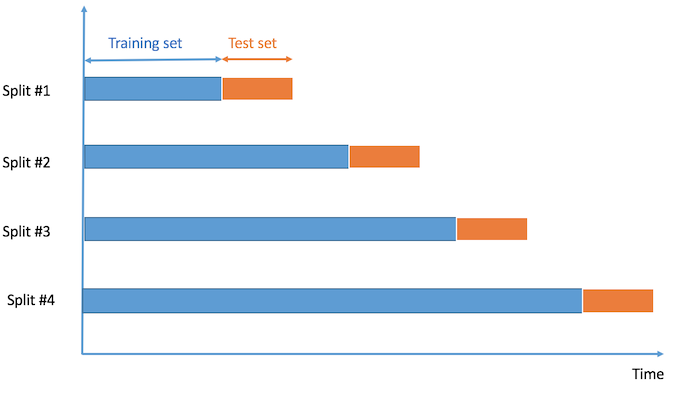

<b>Rolling cross-validation</b> is a technique used to evaluate the performance of time series forecasting models. It involves splitting the dataset into multiple training and testing sets, where the training set gradually increases over time while the testing set remains fixed. This approach helps assess the model's ability to generalize to unseen data by simulating real-world forecasting scenarios. During cross validation, we are gonna evaluate a set of different SARIMA parameters and the select the parameters for each metric across all folds.

In [ ]:
# Define parameters range
p = range(0, 3)
d = range(0, 3)
q = range(0, 3)
P = range(0, 3)
D = range(0, 3)
Q = range(0, 3)
s = [12]

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))

In [ ]:
#Create Rolling Cross validation indices
tscv = TimeSeriesSplit(n_splits=5)
indices = tscv.split(df_train)

In [ ]:
# Define a list to store the results of each model
model_scores = {}

"""
Rolling cross validation
"""
for i, (train_index, test_index) in enumerate(indices):

    y_train = ath.iloc[train_index]
    y_val = ath.iloc[test_index]

    print(f'\n------------Fold {i}-----------')
    fold = f'fold_{i}'

    # Iterate over all possible combinations of hyperparameters
    for param in pdq:
        for param_seasonal in seasonal_pdq:

            # Fit the SARIMA model using the training set
            # model = ARIMA(y_train, order=param, seasonal_order=param_seasonal).fit()
            model = sm.tsa.statespace.SARIMAX(y_train,
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                                enforce_invertibility=False).fit()

            results =  model.get_prediction(y_val.index[0], y_val.index[-1],dynamic=False).summary_frame()
            y_pred = results['mean']
            # y_pred = model.forecast(len(y_val))

            # calculate model prediction metrics
            mape = MAPE(y_val, y_pred)
            mae = MAE(y_val, y_pred)
            rmse = MSE(y_val, y_pred, squared=True)
            AIC = model.aic
            BIC = model.bic

            key = (param, param_seasonal)

            if key not in model_scores:
                # for the first fold we initialize the scores
                results = {'mape': [mape], 'mae': [mae], 'rmse': [rmse], 'aic': [AIC], 'bic': [BIC]}
                model_scores[key] = results
            else:
                # for the rest folds we sum all scores from all folds
                model_scores[key]['mape'].append(mape)
                model_scores[key]['mae'].append(mae)
                model_scores[key]['rmse'].append(rmse)
                model_scores[key]['aic'].append(AIC)
                model_scores[key]['bic'].append(BIC)

mean_scores = model_scores
for param_set in model_scores.keys():
    for metric in ['mape', 'mae', 'rmse', 'aic', 'bic']:
        mean_scores[param_set][metric] = np.mean(model_scores[param_set][metric])

best_params = {}
for metric in ['mape', 'mae', 'rmse', 'aic', 'bic']:
    best_params[metric] = min(mean_scores, key=lambda x: model_scores[x][metric])

print(mean_scores)
print(best_params)


------------Fold 0-----------


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


------------Fold 1-----------


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


------------Fold 2-----------


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op


------------Fold 3-----------


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

{((0, 0, 0), (0, 0, 0, 12)): {'mape': 1.0, 'mae': 18.0193828125, 'rmse': 361.5570362578125, 'aic': 1939.9095368508092, 'bic': 1943.2602656414213}, ((0, 0, 0), (0, 0, 1, 12)): {'mape': 0.9121219785548936, 'mae': 16.409488663040094, 'rmse': 313.7087642513696, 'aic': 1598.093656454544, 'bic': 1604.66977001711}, ((0, 0, 0), (0, 0, 2, 12)): {'mape': 0.8423099805719607, 'mae': 15.11706078080379, 'rmse': 278.6645407547025, 'aic': 1342.8992420363033, 'bic': 1352.5608289369345}, ((0, 0, 0), (0, 1, 0, 12)): {'mape': 0.08221961923603888, 'mae': 1.2214414062500003, 'rmse': 2.533504792968751, 'aic': 776.5914149525317, 'bic': 779.8794717338146}, ((0, 0, 0), (0, 1, 1, 12)): {'mape': 0.06685525793317151, 'mae': 1.002972218149764, 'rmse': 1.5723748842235068, 'aic': 657.5975618223808, 'bic': 664.0386197561348}, ((0, 0, 0), (0, 1, 2, 12)): {'mape': 0.06795951494723151, 'mae': 1.0314471222506576, 'rmse': 1.6412808463300226, 'aic': 615.9354584518521, 'bic': 625.377060890024}, ((0, 0, 0), (0, 2, 0, 12)): {'

In [ ]:
# best parameters for each metric after finetuning
best_params = {'mape': ((2, 0, 1), (1, 0, 1, 12)), 'mae': ((2, 1, 2), (1, 0, 1, 12)), 'rmse': ((2, 0, 1), (1, 0, 1, 12)), 'aic': ((0, 0, 2), (0, 1, 2, 12)), 'bic': ((0, 0, 1), (0, 1, 2, 12))}

After model finetuning, we are gonna select select the model that minimizes the metric that best fits our data. We are going to plot all the 5 models in order to better visualize the forecast on test set.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


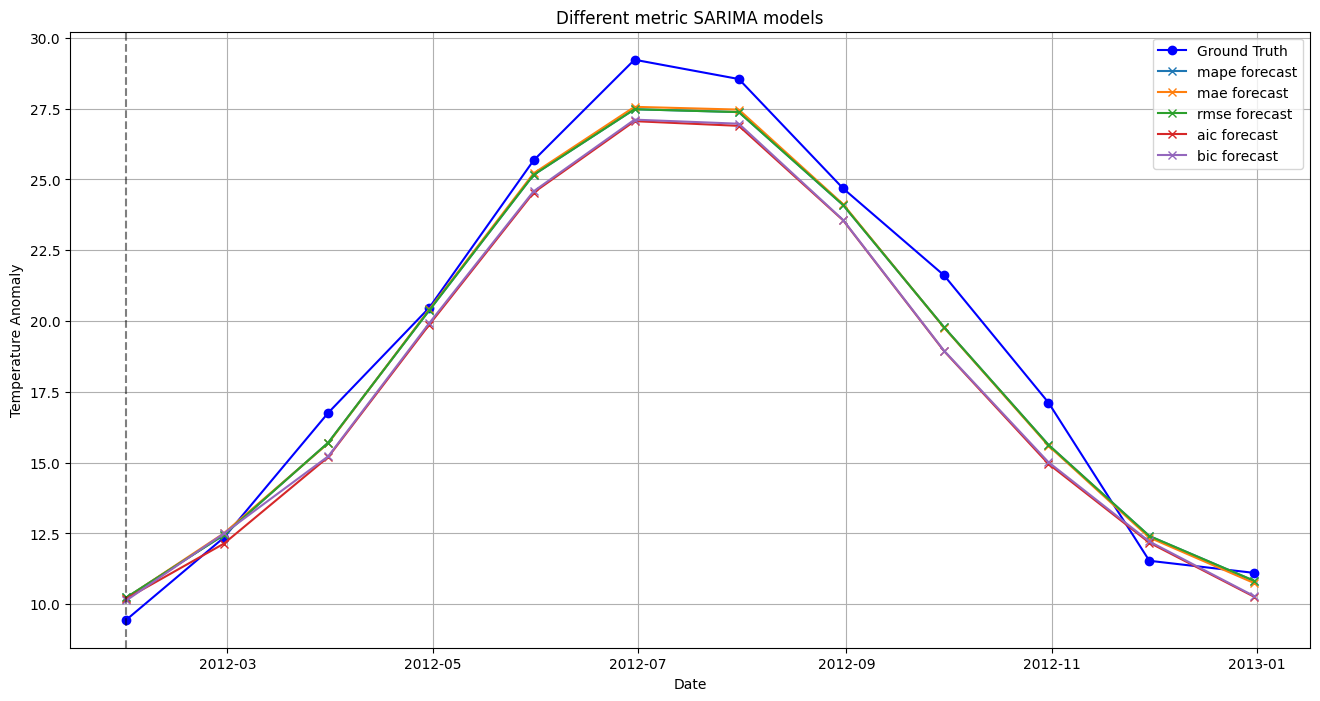

In [ ]:
title = f'Different metric SARIMA models'
plt.figure(figsize=(16,8))
plt.plot(df_test, label='Ground Truth', marker='o', color='blue')

for metric in best_params:

    order_list = best_params[metric][0]
    seasonal_list = best_params[metric][1]
    # train a SARIMA model with best paramters after rolling cross validation
    model = sm.tsa.SARIMAX(df_train, order=order_list, seasonal_order=seasonal_list,enforce_stationarity=False,enforce_invertibility=False).fit()
    forecasts = model.forecast(steps=12)
    plt.plot(df_test.index,forecasts, label=f'{metric} forecast' , marker='x')

plt.title(title)
plt.xlabel('Date')
plt.ylabel('Temperature Anomaly')
plt.axvline(df_test.index[0], color='black', alpha=0.5, linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

As we can see, all models that minimize the selected metrics are close to the test data. For our final SARIMA model, we are gonna select the model that minimizes <b>RMSE</b> error.

In [ ]:
order_list = [2, 0, 1]
seasonal_list = [1, 0, 1, 12]

#### One Year Forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAPE : 0.04794189053654124
MAE : 0.8764847949503317
MSE : 1.1008392300452936
RMSE : 1.0492088591149493
r2 : 0.9756965161996822


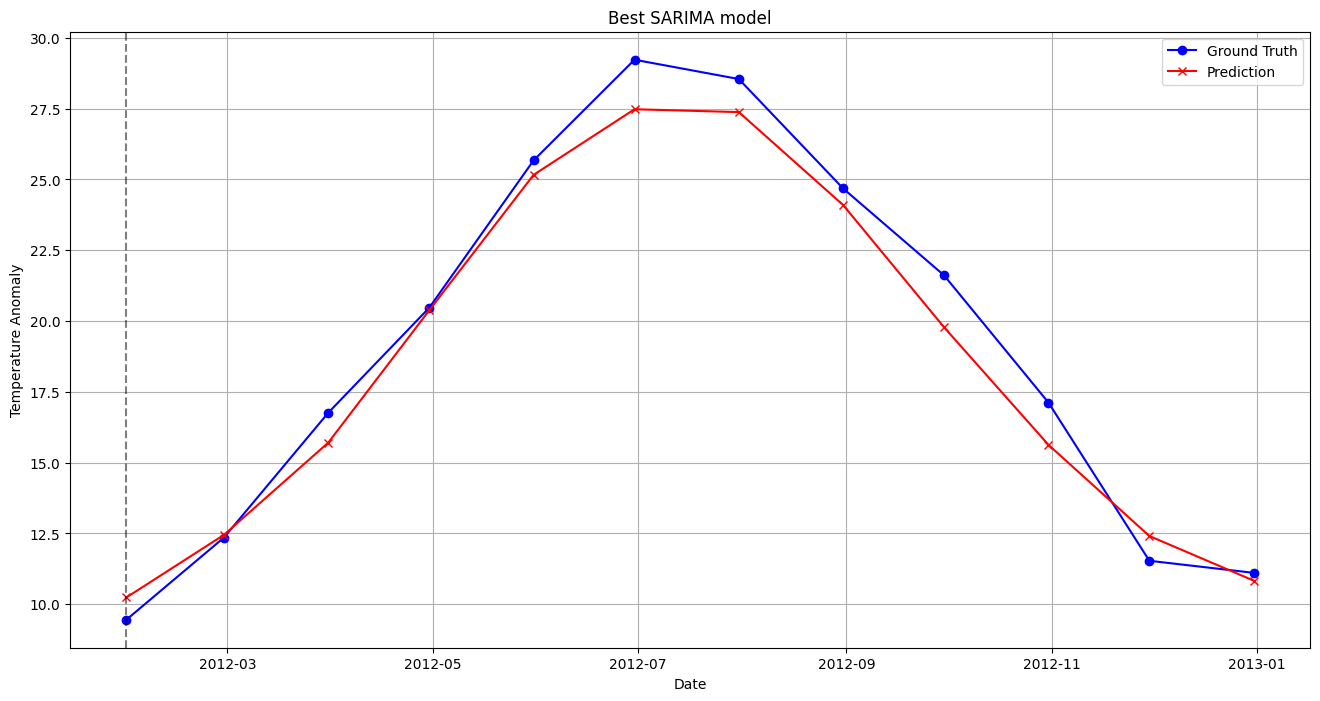

In [ ]:
# split data in order to forecast last year and train on the rest
split_date = '2012-01-01'
df_train, df_test = ath.loc[(ath.index < split_date)], ath[(ath.index >= split_date)]

# train a SARIMA model with best paramters after rolling cross validation
model = sm.tsa.SARIMAX(df_train, order=order_list, seasonal_order=seasonal_list,enforce_stationarity=False,enforce_invertibility=False)
fitted_model = model.fit()

sarima_forecast_1 = fitted_model.forecast(steps=12)
evaluate_model(df_test, sarima_forecast_1)
plot_single_model('SARIMA', df_test, sarima_forecast_1)

#### Two years forecast

For this experiment, we use the SARIMA model to forecast the last two year(2011-2012). Thus, we train the model with the rest temperature data.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAPE : 0.07230374438988667
MAE : 1.0794696662296983
MSE : 1.8639901247691244
RMSE : 1.3652802367166692
r2 : 0.9579945590511229


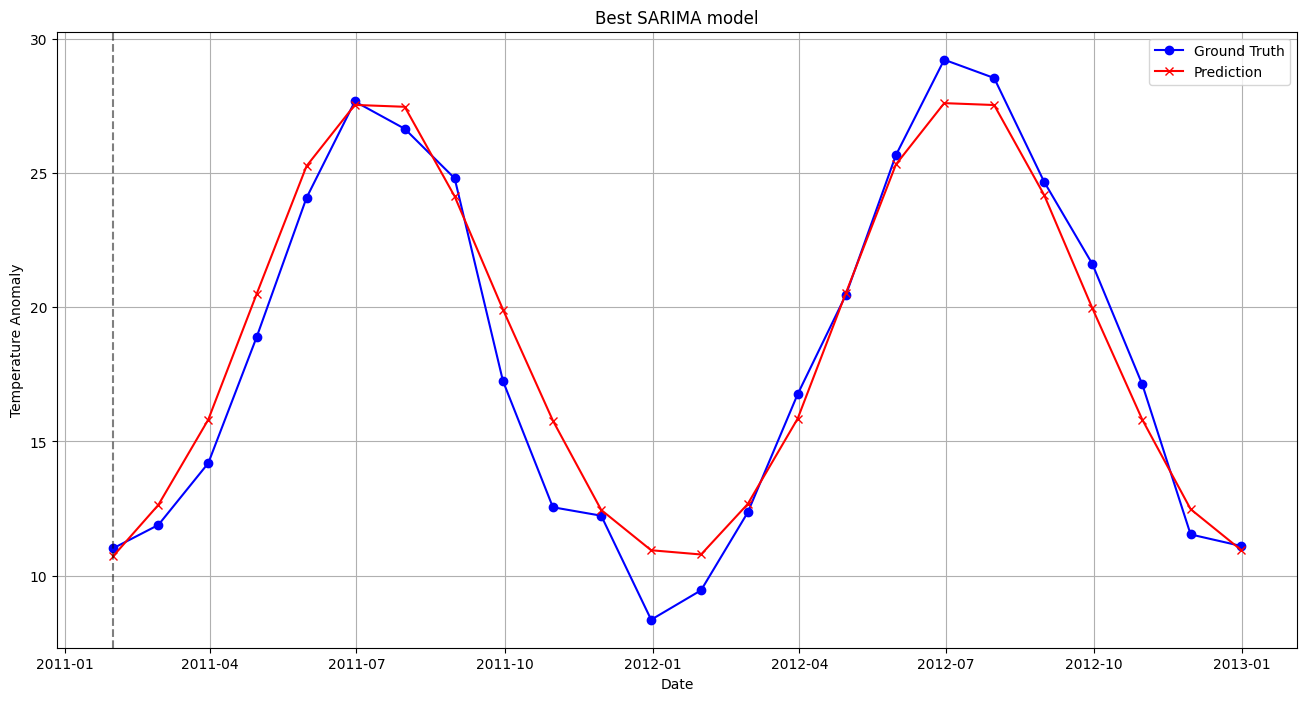

In [ ]:
# split data in order to forecast last year and train on the rest
split_date = '2011-01-01'
df_train_2, df_test_2 = ath.loc[(ath.index < split_date)], ath[(ath.index >= split_date)]

# train a SARIMA model with best paramters after rolling cross validation
model = sm.tsa.SARIMAX(df_train_2, order=order_list, seasonal_order=seasonal_list,enforce_stationarity=False,enforce_invertibility=False)
fitted_model = model.fit()

sarima_forecast_2 = fitted_model.forecast(steps=24)
evaluate_model(df_test_2, sarima_forecast_2)
plot_single_model('SARIMA', df_test_2, sarima_forecast_2)

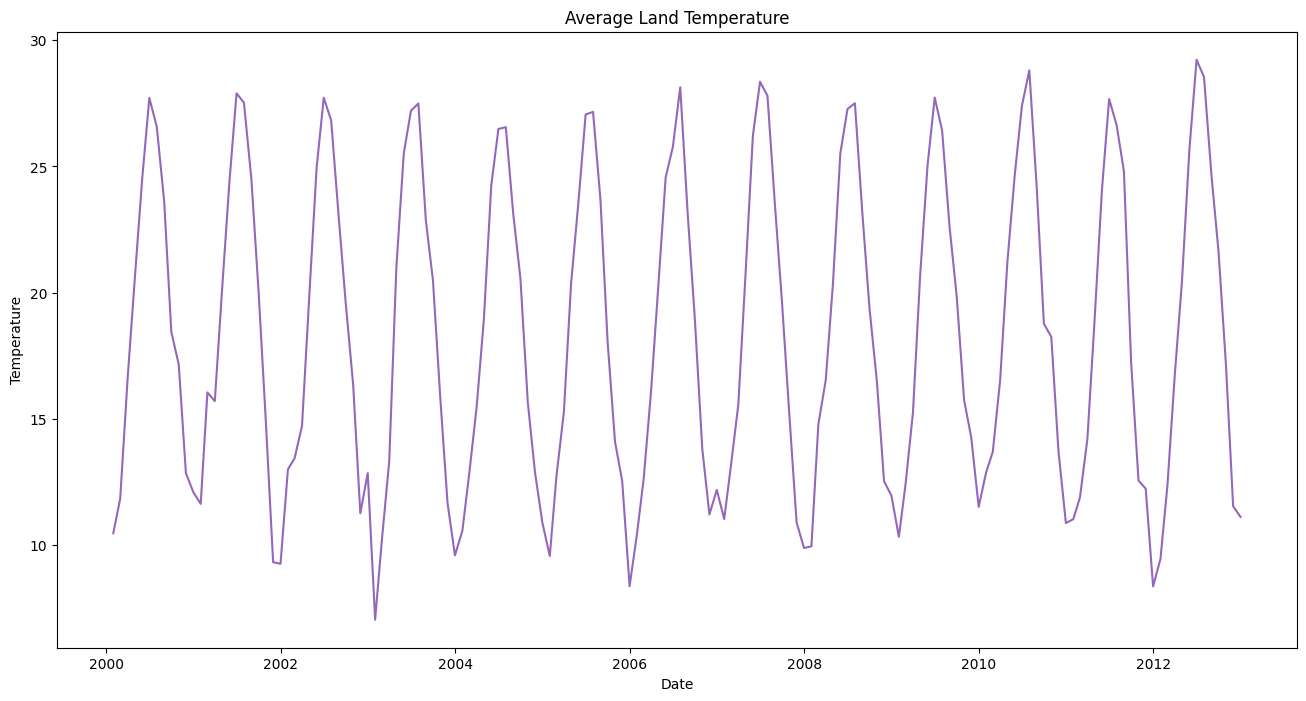

In [ ]:
plot_ts(ath.loc['2000':'2013-01-01'])

### XGBoost forecasting

<b>XGBoost</b> is a popular ML algorithm known for its efficiency
and effectiveness. It belongs to the gradient boosting family and is used for
regression and classification.


![xgb_arch.png](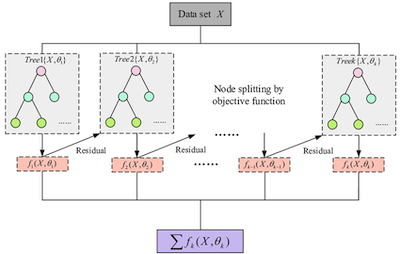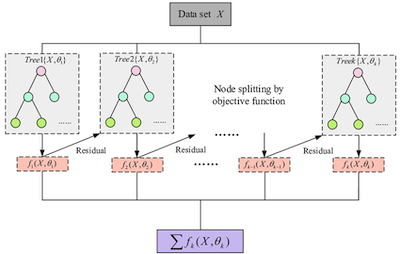)

<br><br>
<b>How XGBoost Works?</b>
- <b>Gradient Boosting:</b> XGBoost combines weak models to
create a strong predictive model.
- <b>Decision Trees:</b> XGBoost builds decision trees as base
learners.
- <b>Boosting Process:</b> Trees are fitted to residuals, correcting
errors made by previous trees.
- <b>Regularization:</b> Techniques like L1 and L2 regularization
prevent overfitting

For this implementation, we are going to split datetime index into 'Month' and 'Year'.

In [ ]:
# Calculate lagged variables
dfs = ath.copy()

dfs['Month'] = dfs.index.month
dfs['Year'] = dfs.index.year
dfs.reset_index(drop=True, inplace=True)
dfs

,Temp,Month,Year
0,11.482,1,1979
1,13.711,2,1979
2,14.582,3,1979
3,19.349,4,1979
4,24.503,5,1979
...,...,...,...
403,24.683,8,2012
404,21.613,9,2012
405,17.123,10,2012
406,11.533,11,2012


In [ ]:
# Split the DataFrame into training and testing sets
train_df = dfs[dfs.Year < 2012]
test_df = dfs[dfs.Year >= 2012]

# Splitting features (X) and target (y)
X_train = train_df.drop(columns=['Temp'])
y_train = train_df['Temp']
X_test = test_df.drop(columns=['Temp'])
y_test = test_df['Temp']

We will conduct a cross-validation procedure with 5 folds using grid search to determine the optimal parameters for the XGBoost model. This approach allows us to systematically evaluate the model's performance across different parameter configurations and select the combination that yields the best results across all folds.

In [ ]:
# parameters to check for XGB
XGB_param_grid = {
    'n_estimators': [150, 500, 700, 1000],
    'max_depth': [1,3, 5, 7],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
}

xgb_model = XGBRegressor(objective='reg:squarederror')

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=XGB_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=10)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print(f"XGB best Hyperparameters:")
print(best_params)

Fitting 5 folds for each of 6912 candidates, totalling 34560 fits
XGB best Hyperparameters:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 150, 'subsample': 0.9}


#### One year Forecast

MAPE : 0.07735439549248173
MAE : 1.548393607457479
MSE : 3.2503614809900117
RMSE : 1.802875891732432
r2 : 0.9282410133628981


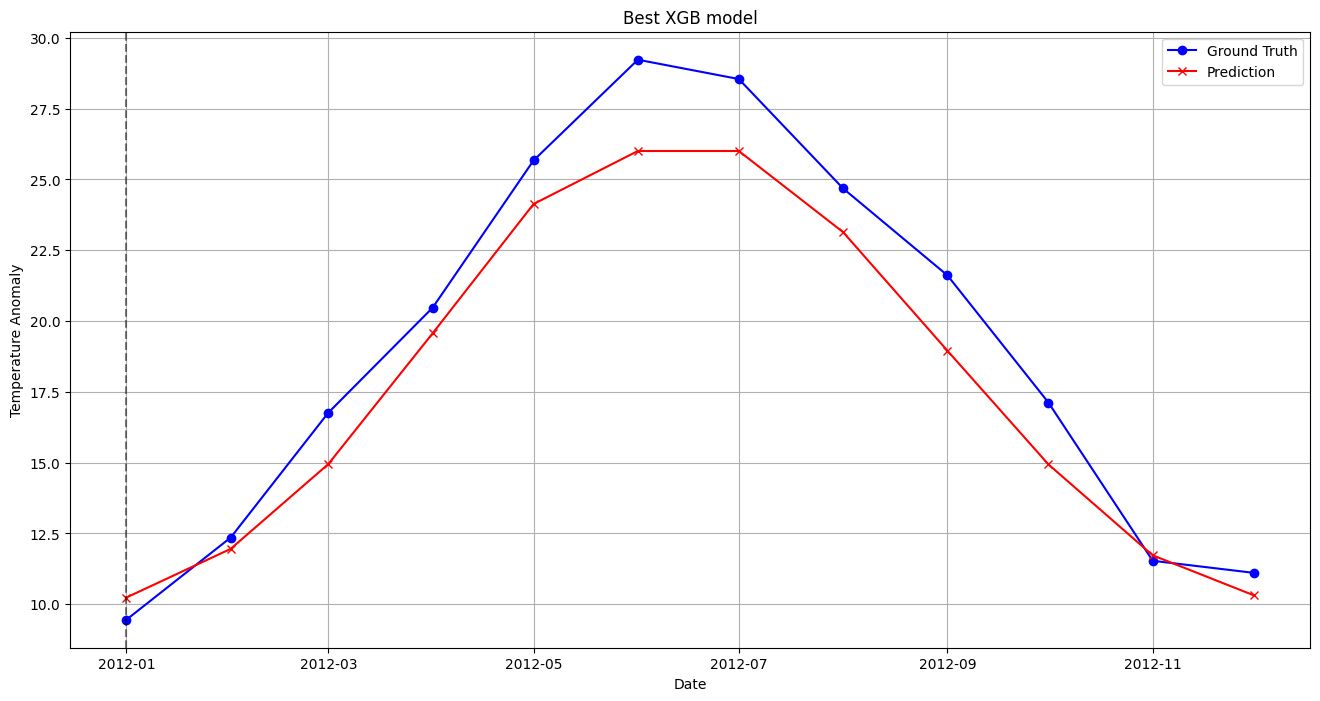

In [ ]:
# Training an XGBoost model
xgb_best_params = {'objective':'reg:squarederror','colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 150, 'subsample': 0.9}
xgb_model = XGBRegressor(**xgb_best_params)
xgb_model.fit(X_train, y_train)

# Making predictions on the test set
xgb_forecast_1 = xgb_model.predict(X_test)


evaluate_model(y_test, xgb_forecast_1)
plot_single_model('XGB', pd.concat([X_test, y_test], axis=1), xgb_forecast_1)

#### Two years Forecast

MAPE : 0.1100709901886755
MAE : 1.5283207976023359
MSE : 1.8830087559886493
RMSE : 3.5457219751299207
r2 : 0.9200963497240073


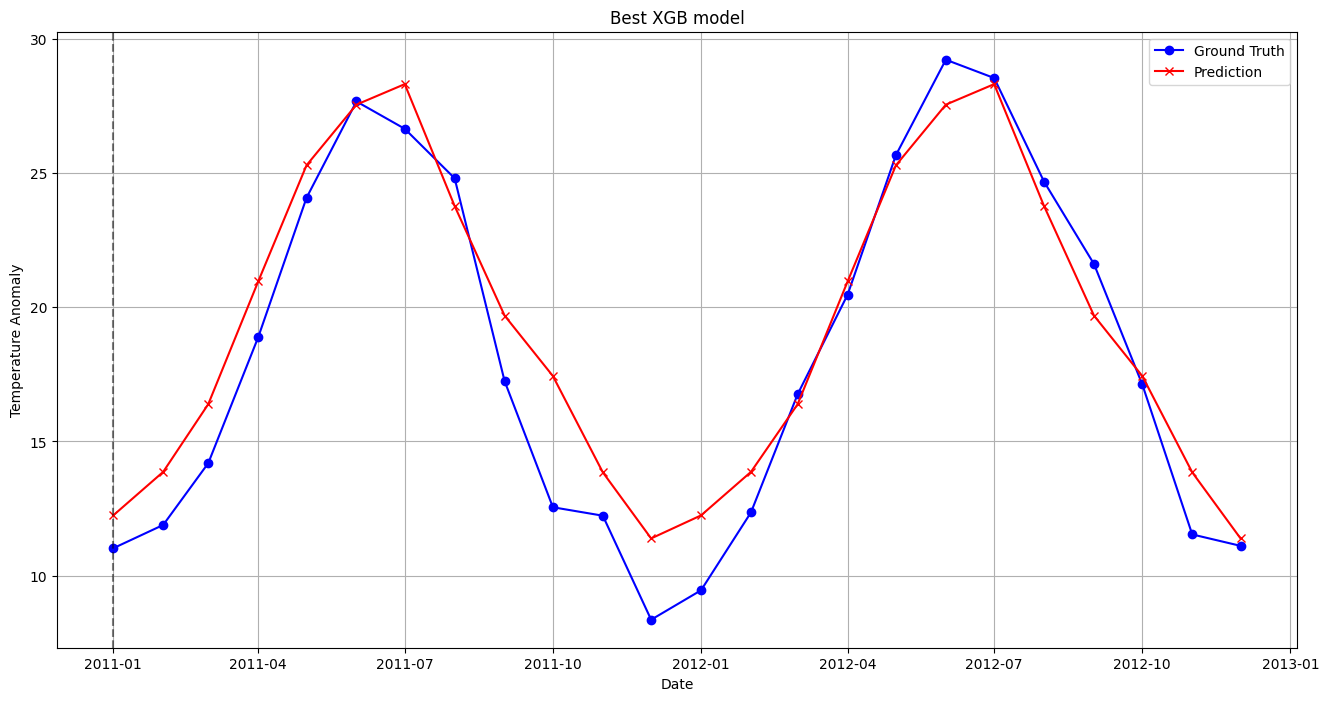

In [ ]:
# Split the DataFrame into training and testing sets
train_df = dfs[dfs.Year < 2011]
test_df = dfs[dfs.Year >= 2011]

# Splitting features (X) and target (y)
X_train = train_df.drop(columns=['Temp'])  # Assuming 'Temp' is the target column
y_train = train_df['Temp']
X_test = test_df.drop(columns=['Temp'])  # Assuming 'Temp' is the target column
y_test = test_df['Temp']

# Training an XGBoost model
xgb_best_params = {'objective':'reg:squarederror', 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500}
xgb_model = XGBRegressor(**xgb_best_params)
xgb_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = xgb_model.predict(X_test)


evaluate_model(y_test, y_pred)
plot_single_model('XGB', pd.concat([X_test, y_test], axis=1), y_pred)

### LSTM forecasting

![lstm.png](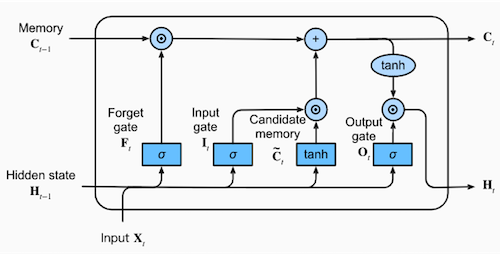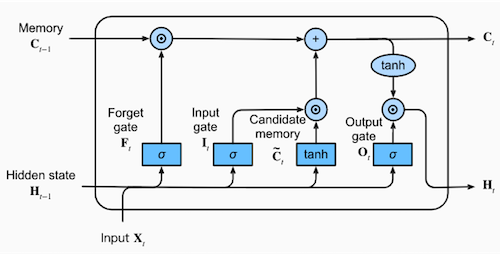)

LSTMs, or Long Short Term Memory Networks, belong to the category of Recurrent Neural Networks (RNNs) and are adept at processing sequential data by retaining information over extended sequences. They achieve this by utilizing specialized units comprising a cell, input gate, output gate, and forget gate, enabling them to capture and retain important information across varying time intervals. Given their ability to handle temporal dependencies and accommodate irregular time lags within time series data, LSTMs are well-suited for tasks such as classification, processing, and forecasting based on sequential data.

In [ ]:
dfl = ath.copy()

split_date = '2012-01-01'
df_train, df_test = dfl.loc[(dfl.index < split_date)], dfl[(dfl.index >= split_date)]

# scale our train data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(np.array(df_train).reshape(-1, 1))

# A window size of 12 is often preferred in LSTM models because it aligns with
# the seasonal pattern of monthly data, enabling the network to capture recurring patterns over a yearly cycle.
window_size = 12
train_generator = TimeseriesGenerator(train_scaled,
                                      train_scaled,
                                      length = window_size,
                                      batch_size = 1)

In [ ]:
lstm_model = Sequential([
        LSTM(100, input_shape = (window_size, 1), return_sequences = True),
        LSTM(50, return_sequences = True),
        LSTM(10),
        Dense(64, activation ='relu'),
        Dense(32, activation ='relu'),
        Dense(1)
])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 12, 50)            30200     
                                                                 
 lstm_2 (LSTM)               (None, 10)                2440      
                                                                 
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 76257 (297.88 KB)
Trainable params: 76257 

In [ ]:
lstm_model.compile(loss = 'mse', optimizer = 'adam')
lstm_history = lstm_model.fit(train_generator, epochs = 100)

Epoch 1/100
384/384 [==============================] - 16s 20ms/step - loss: 0.2285
Epoch 2/100
384/384 [==============================] - 7s 19ms/step - loss: 0.0911
Epoch 3/100
384/384 [==============================] - 7s 17ms/step - loss: 0.0982
Epoch 4/100
384/384 [==============================] - 10s 25ms/step - loss: 0.0926
Epoch 5/100
384/384 [==============================] - 8s 21ms/step - loss: 0.0750
Epoch 6/100
384/384 [==============================] - 7s 19ms/step - loss: 0.0659
Epoch 7/100
384/384 [==============================] - 8s 21ms/step - loss: 0.0757
Epoch 8/100
384/384 [==============================] - 7s 18ms/step - loss: 0.0759
Epoch 9/100
384/384 [==============================] - 6s 17ms/step - loss: 0.0747
Epoch 10/100
384/384 [==============================] - 9s 23ms/step - loss: 0.0662
Epoch 11/100
384/384 [==============================] - 6s 17ms/step - loss: 0.0672
Epoch 12/100
384/384 [==============================] - 8s 21ms/step - loss: 0.0626

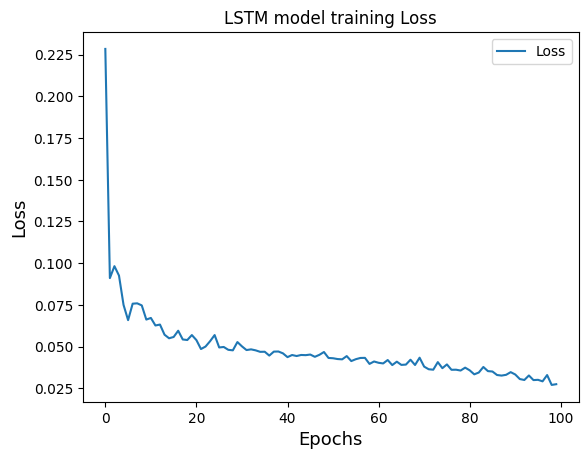

In [ ]:
# plot loss
plt.plot(lstm_history.history["loss"])
plt.xlabel("Epochs", fontsize = 13)
plt.ylabel("Loss", fontsize = 13)
plt.legend(["Loss"])
plt.title("LSTM model training Loss")
plt.show()

1/1 [==============================] - 0s 23ms/step
MAPE : 0.10253074160916892
MAE : 1.8626727655999116
MSE : 2.597311858783543
RMSE : 6.746028891777623
r2 : 0.8510663506413668


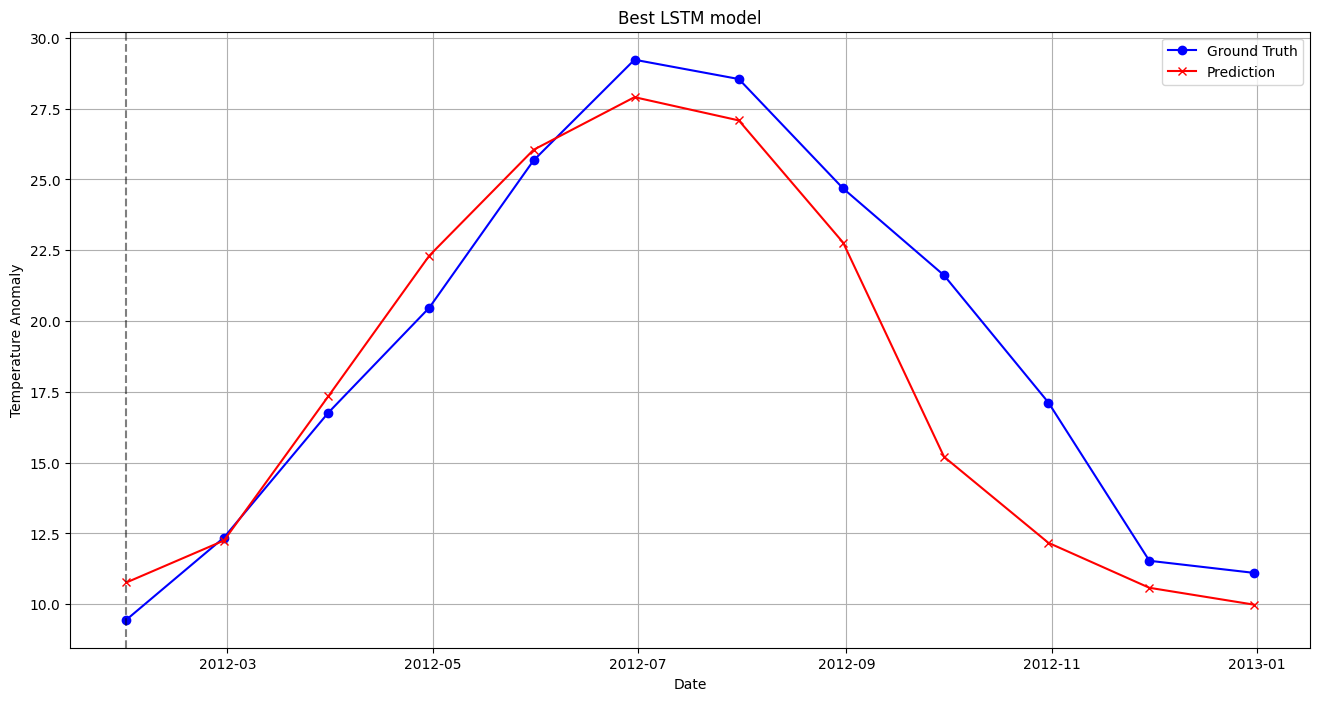

In [ ]:
#Creating an empty forecasts list:
lstm_predictions_scaled = []

#Creating a batch of the latest data points based on the window size for forecast:
batch = train_scaled[-window_size:]
#Reshaping the batch as per model requirements:
current_batch = batch.reshape((1, window_size, 1))

#Iteratively making the forecast for each month of the next year:
for i in range(len(df_test)):
    #Forecasting the next month using previous 14 (window size) data points.
    lstm_pred = lstm_model.predict(current_batch)[0]
    #Appending the next month forecast to the forecasts list:
    lstm_predictions_scaled.append(lstm_pred)
    #Appending the next month forecast to the current batch and
    #removing the earliest data point in its place to preserve the window size:
    current_batch = np.append(current_batch[:, 1:, :], [[lstm_pred]], axis = 1)

#Since the original values were scaled before training the model, we need to
#inverse scale the forecast in order to get the forecast for the original data.
lstm_forecast_1 = scaler.inverse_transform(lstm_predictions_scaled)
evaluate_model(df_test, lstm_forecast_1)
plot_single_model('LSTM', df_test, lstm_forecast_1)

Let's check another LSTM model architecture.

In [ ]:
lstm_model_dropout = Sequential([
        LSTM(100, input_shape = (window_size, 1), return_sequences = True),
        Dropout(0.2),
        LSTM(50, return_sequences = True),
        Dropout(0.2),
        LSTM(10),
        Dropout(0.2),
        Dense(64, activation ='relu'),
        Dense(32, activation ='relu'),
        Dense(1)
])

print(lstm_model_dropout.summary())

lstm_model_dropout.compile(loss = 'mse', optimizer = 'adam')
lstm_dropout_history = lstm_model_dropout.fit(train_generator, epochs = 100)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 12, 100)           40800     
                                                                 
 dropout_3 (Dropout)         (None, 12, 100)           0         
                                                                 
 lstm_7 (LSTM)               (None, 12, 50)            30200     
                                                                 
 dropout_4 (Dropout)         (None, 12, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 10)                2440      
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                                 
 dense_6 (Dense)             (None, 64)               

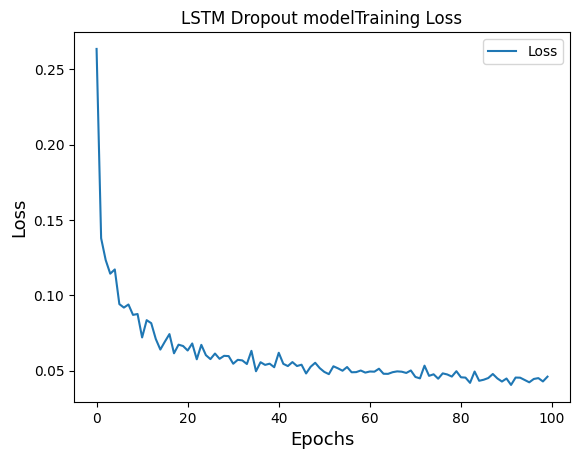

In [ ]:
# plot loss
plt.plot(lstm_dropout_history.history["loss"])
plt.xlabel("Epochs", fontsize = 13)
plt.ylabel("Loss", fontsize = 13)
plt.legend(["Loss"])
plt.title("LSTM Dropout model Training Loss")
plt.show()

1/1 [==============================] - 0s 23ms/step
MAPE : 0.09933196997114824
MAE : 1.9454217595378502
MSE : 2.2865563243823575
RMSE : 5.228339824572956
r2 : 0.8845727252799328


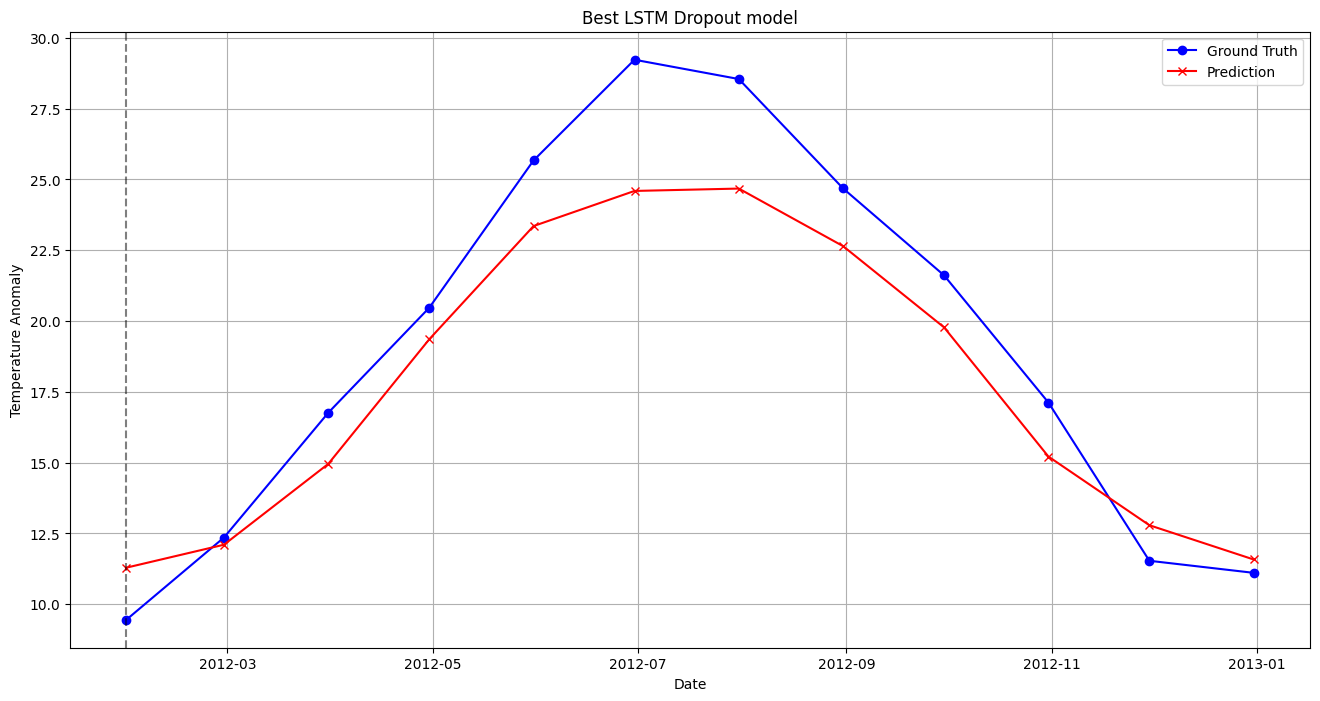

In [ ]:
#Creating an empty forecasts list:
lstm_predictions_scaled = []

#Creating a batch of the latest data points based on the window size for forecast:
batch = train_scaled[-window_size:]
#Reshaping the batch as per model requirements:
current_batch = batch.reshape((1, window_size, 1))

#Iteratively making the forecast for each month of the next year:
for i in range(len(df_test)):
    #Forecasting the next month using previous 14 (window size) data points.
    lstm_pred = lstm_model_dropout.predict(current_batch)[0]
    #Appending the next month forecast to the forecasts list:
    lstm_predictions_scaled.append(lstm_pred)
    #Appending the next month forecast to the current batch and
    #removing the earliest data point in its place to preserve the window size:
    current_batch = np.append(current_batch[:, 1:, :], [[lstm_pred]], axis = 1)

#Since the original values were scaled before training the model, we need to
#inverse scale the forecast in order to get the forecast for the original data.
lstm_dropout_forecasts_1 = scaler.inverse_transform(lstm_predictions_scaled)
evaluate_model(df_test, lstm_dropout_forecasts_1)
plot_single_model('LSTM Dropout', df_test, lstm_dropout_forecasts_1)

### Model comparison

We plot the best evaluated models along side with the temperatures of test set, i.e the last year 2012.

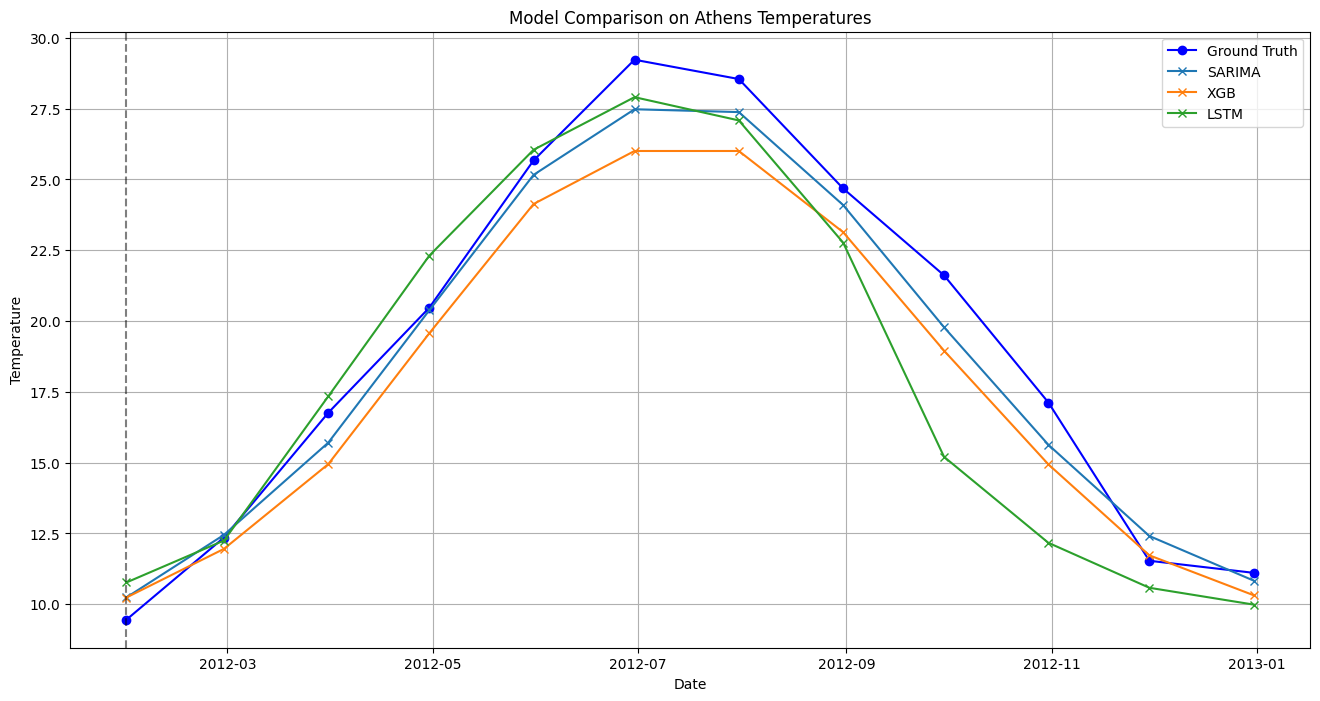

In [ ]:
title = f'Model Comparison on Athens Temperatures'
plt.figure(figsize=(16,8))
plt.plot(df_test, label='Ground Truth', marker='o', color='blue')
plt.plot(df_test.index,sarima_forecast_1, label='SARIMA' , marker='x')
plt.plot(df_test.index,xgb_forecast_1, label='XGB' , marker='x')
plt.plot(df_test.index,lstm_forecast_1, label='LSTM' , marker='x')
plt.title(title)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.axvline(df_test.index[0], color='black', alpha=0.5, linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

\begin{aligned}
&\begin{array}{cccc}
\hline \hline \textbf { Algorithm } & \textbf { MAE } & \textbf { MSE } & \textbf { RMSE } & \textbf { MAPE } & \textbf { $r^2$ } \\
\hline \text{SARIMA} & \mathbf{0.87} & \mathbf{1.1} & \mathbf{1.04} & \mathbf{0.04} & \mathbf{0.97}\\
\text{XGBoost} & 1.54 & 3.25 & 1.8 & 0.07 & 0.92\\
\text{LSTM} & 1.94 & 5.22 & 2.28 & 0.09 & 0.88\\
\hline
\end{array}
\end{aligned}


<br><br>
Based on the comparison of the models on the above table, SARIMA demonstrates superior performance across multiple metrics, including MAE, MSE, RMSE, MAPE, and r2r2. This outcome suggests that SARIMA captures the underlying patterns in the data more effectively than XGBoost and LSTM. Furthermore, XGBoost outperforms LSTM in the 1-year forecast, which could be attributed to XGBoost's ability to handle complex nonlinear relationships and interactions in the data more efficiently than LSTM for this specific task

## Future Forecast

For our last experiment, we are going to utilize the best model (SARIMA) to forecast several years in the furure. We are going to forecast average monthly Temperature in Athens from 2013 - 2027

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


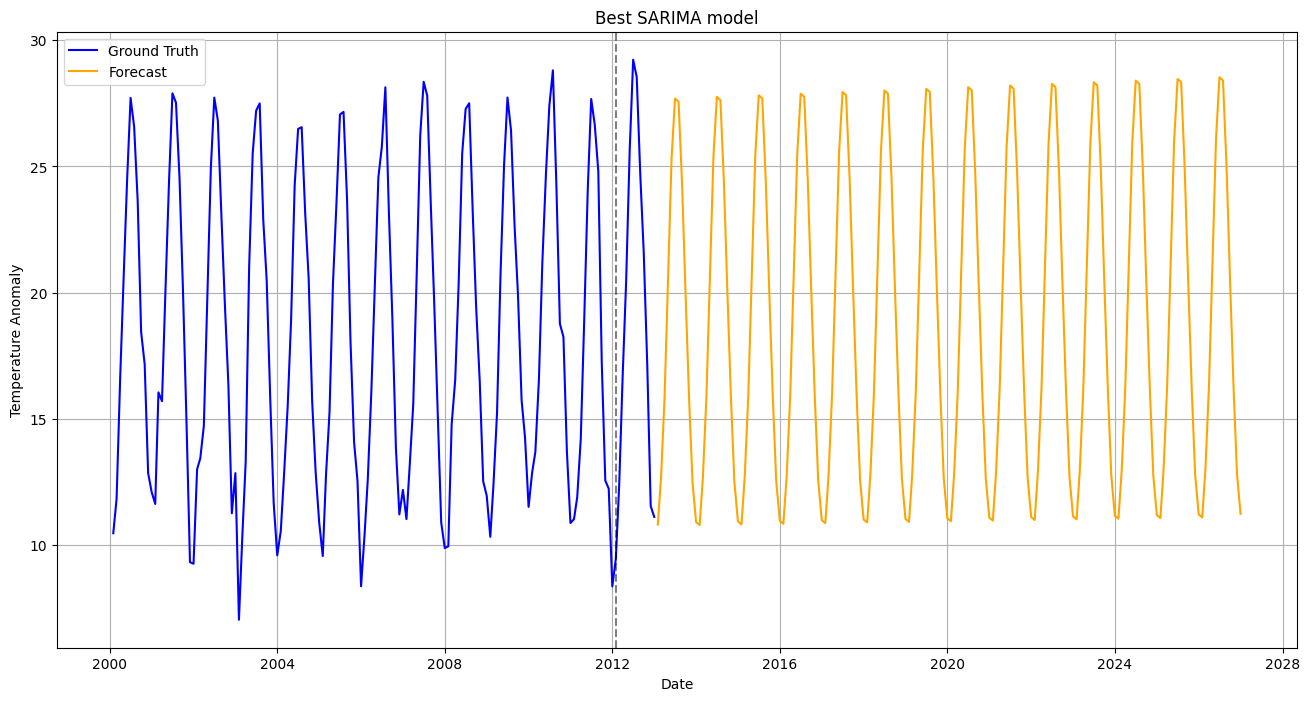

In [ ]:
# train a SARIMA model with best paramters with the whole Athens dataset
model = sm.tsa.SARIMAX(ath, order=order_list, seasonal_order=seasonal_list,enforce_stationarity=False,enforce_invertibility=False)
fitted_model = model.fit()

sarima_future_forecast = fitted_model.forecast(steps=14*12)
plot_future_forecast('SARIMA', ath, 14, sarima_future_forecast)